https://paperswithcode.com/search?q=vessel 

In [ ]:
!pip install pretrainedmodels -q
!pip install albumentations -q

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 634kB 5.3MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mkdir models/

In [ ]:
ls drive/Shareddrives

In [ ]:
!cp drive/'My Drive'/DS-APPS/ml/ml_project/data/microscopy_data.zip data.zip

In [ ]:
mkdir data/

In [ ]:
!unzip data.zip 

Archive:  data.zip
  inflating: Y_val.npy               
  inflating: __MACOSX/._Y_val.npy    
  inflating: Y_train.npy             
  inflating: __MACOSX/._Y_train.npy  
  inflating: X_train_BF.npy          
  inflating: __MACOSX/._X_train_BF.npy  
  inflating: X_val_BF.npy            
  inflating: __MACOSX/._X_val_BF.npy  
  inflating: X_test_BF.npy           
  inflating: __MACOSX/._X_test_BF.npy  
  inflating: X_val_FL.npy            
  inflating: __MACOSX/._X_val_FL.npy  
  inflating: X_train_FL.npy          
  inflating: __MACOSX/._X_train_FL.npy  
  inflating: X_test_FL.npy           
  inflating: __MACOSX/._X_test_FL.npy  


In [ ]:
import numpy as np


In [ ]:
# choose br or fl
# X_train = np.load('X_train_FL.npy')
X_train = np.load('X_train_BF.npy')
y_train = np.load('Y_train.npy')



In [ ]:
# X_val = np.load('X_val_FL.npy')
X_val = np.load('X_val_BF.npy')
y_val = np.load('Y_val.npy')



In [ ]:
from tqdm import tqdm
import cv2

In [ ]:
!mkdir data/images
!mkdir data/masks

mkdir: cannot create directory ‘data/images’: File exists
mkdir: cannot create directory ‘data/masks’: File exists


In [ ]:
!ls data

images	masks


In [ ]:
req_shape = 320
def save_images(train, mask, st_ind=0, root_folder='data'):
    for i in tqdm(range(train.shape[0])):
        img = train[i].squeeze()
        cv2.imwrite(f"{root_folder}/images/{i + st_ind}.jpg", img)
        img_mask = mask[i].squeeze()
        cv2.imwrite(f"{root_folder}/masks/{i + st_ind}.png", img_mask)

def prepare_cropped_img(img):
    img = cv2.resize(img, dsize=(req_shape * 3, req_shape * 3)) #960x960 from 1020x1020
    # print(img.shape)
    imgs = []
    for i in range(3):
        for j in range(3):
            cur_img = img[i * req_shape:(i + 1) * req_shape, j * req_shape:(j + 1) * req_shape]
            # print(cur_img.shape)
            imgs.append(cur_img)
    return imgs

def save_images_crop(train, mask, st_ind=0, root_folder='data'):
    for i in tqdm(range(train.shape[0])):
        img = train[i].squeeze()
        imgs = prepare_cropped_img(img)
        for j, part_img in enumerate(imgs):
            # print(part_img.shape)
            cv2.imwrite(f"{root_folder}/images/{i + st_ind}_{j}.jpg", part_img)
        img_mask = mask[i].squeeze()
        imgs_mask = prepare_cropped_img(img_mask)
        for j, part_img in enumerate(imgs_mask):
            cv2.imwrite(f"{root_folder}/masks/{i + st_ind}_{j}.png", part_img)

In [ ]:
save_images_crop(X_train, y_train, 0)
save_images_crop(X_val, y_val, X_train.shape[0])

100%|██████████| 504/504 [00:09<00:00, 53.17it/s]


In [ ]:
from matplotlib import pyplot as plt 

import torch 
import torch.nn as nn

def dice_loss(preds, trues, weight=None, is_average=True, eps=1):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = 2. * (intersection + eps) / (preds.sum(1) + trues.sum(1) + eps)

    if is_average:
        score = scores.sum() / num
        return torch.clamp(score, 0., 1.)
    else:
        return scores

    
def jaccard_loss(preds, trues, weight=None, is_average=True, eps=1e-3):
    num = preds.size(0)
    preds = preds.view(num, -1)
    trues = trues.view(num, -1)
    if weight is not None:
        w = torch.autograd.Variable(weight).view(num, -1)
        preds = preds * w
        trues = trues * w
    intersection = (preds * trues).sum(1)
    scores = (intersection + eps) / ((preds + trues).sum(1) - intersection + eps)

    if is_average:
        score = scores.sum()/num
        return torch.clamp(score, 0., 1.)
    else:
        return scores


def dice_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return dice_loss(preds, trues, is_average=is_average)


def jaccard_clamp(preds, trues, is_average=True):
    preds = torch.round(preds)
    return jaccard_loss(preds, trues, is_average=is_average)    


class FocalLossBinary(nn.Module):
    """Focal loss puts more weight on more complicated examples.
    https://github.com/warmspringwinds/pytorch-segmentation-detection/blob/master/pytorch_segmentation_detection/losses.py
    output is log_softmax
    """

    def __init__(self, gamma=2, size_average=True, reduce=True):
        super(FocalLossBinary, self).__init__(size_average=size_average, reduce=reduce)
        self.gamma = gamma

    def forward(self, outputs, targets):

        outputs = F.logsigmoid(outputs)
        logpt = -F.binary_cross_entropy_with_logits(outputs, targets.float(), reduce=False)
        pt = torch.exp(logpt)

        # compute the loss
        loss = -((1 - pt).pow(self.gamma)) * logpt

        # averaging (or not) loss
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

        
class DiceLoss(nn.Module):
    def __init__(self, size_average=True, eps=1):
        super().__init__()
        self.size_average = size_average
        self.eps = eps

    def forward(self, input, target, weight=None):
        return 1-dice_loss(torch.sigmoid(input), target, 
                           weight=weight, is_average=self.size_average, eps=self.eps)


class BCEDiceLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.dice = DiceLoss(size_average=size_average)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(size_average=self.size_average, 
                                                 weight=weight)(input, target) + self.dice(input, target, weight=weight)
    
class JaccardLoss(nn.Module):
    def __init__(self, size_average=True, eps=100):
        super().__init__()
        self.size_average = size_average
        self.eps = eps

    def forward(self, input, target, weight=None):
        return 1-jaccard_loss(torch.sigmoid(input), target, 
                              weight=weight, is_average=self.size_average, eps=self.eps)


class BCEJaccardLoss(nn.Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average
        self.eps = 100
        self.jaccard = JaccardLoss(size_average=size_average, eps=self.eps)

    def forward(self, input, target, weight=None):
        return nn.modules.loss.BCEWithLogitsLoss(size_average=self.size_average, 
                                                 weight=weight)(input, target) + self.jaccard(input, target, weight=weight)

In [ ]:
import torch


def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer, cpu=False):
    if cpu:
        state = torch.load(checkpoint_path, map_location='cpu')
    else:
        state = torch.load(checkpoint_path, )
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

In [ ]:

from torch import nn
from torch.nn import functional as F
import torch
from torchvision import models
import torchvision
from pretrainedmodels import models as pmodels

def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)


class ConvRelu(nn.Module):
    def __init__(self, in_, out):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            ConvRelu(in_channels, middle_channels),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class UNet11(nn.Module):
    def __init__(self, num_filters=32, pretrained=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
        """
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = models.vgg11(pretrained=pretrained).features

        self.relu = self.encoder[1]
        self.conv1 = self.encoder[0]
        self.conv2 = self.encoder[3]
        self.conv3s = self.encoder[6]
        self.conv3 = self.encoder[8]
        self.conv4s = self.encoder[11]
        self.conv4 = self.encoder[13]
        self.conv5s = self.encoder[16]
        self.conv5 = self.encoder[18]

        self.center = DecoderBlock(num_filters * 8 * 2, num_filters * 8 * 2, num_filters * 8)
        self.dec5 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 8)
        self.dec4 = DecoderBlock(num_filters * (16 + 8), num_filters * 8 * 2, num_filters * 4)
        self.dec3 = DecoderBlock(num_filters * (8 + 4), num_filters * 4 * 2, num_filters * 2)
        self.dec2 = DecoderBlock(num_filters * (4 + 2), num_filters * 2 * 2, num_filters)
        self.dec1 = ConvRelu(num_filters * (2 + 1), num_filters)

        self.final = nn.Conv2d(num_filters, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.relu(self.conv1(x))
        conv2 = self.relu(self.conv2(self.pool(conv1)))
        conv3s = self.relu(self.conv3s(self.pool(conv2)))
        conv3 = self.relu(self.conv3(conv3s))
        conv4s = self.relu(self.conv4s(self.pool(conv3)))
        conv4 = self.relu(self.conv4(conv4s))
        conv5s = self.relu(self.conv5s(self.pool(conv4)))
        conv5 = self.relu(self.conv5(conv5s))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)


def unet11(pretrained=False, **kwargs):
    """
    pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with VGG11
            carvana - all weights are pre-trained on
                Kaggle: Carvana dataset https://www.kaggle.com/c/carvana-image-masking-challenge
    """
    model = UNet11(pretrained=pretrained, **kwargs)

    if pretrained == 'carvana':
        state = torch.load('TernausNet.pt')
        model.load_state_dict(state['model'])
    return model


class Interpolate(nn.Module):
    def __init__(self, size=None, scale_factor=None, mode='nearest', align_corners=False):
        super(Interpolate, self).__init__()
        self.interp = nn.functional.interpolate
        self.size = size
        self.mode = mode
        self.scale_factor = scale_factor
        self.align_corners = align_corners
        
    def forward(self, x):
        x = self.interp(x, size=self.size, scale_factor=self.scale_factor, 
                        mode=self.mode, align_corners=self.align_corners)
        return x


class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                Interpolate(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)


class ResNet43Unet(nn.Module):
    """
        UNet (https://arxiv.org/abs/1505.04597) with Resnet34(https://arxiv.org/abs/1512.03385) encoder
        Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/
        """

    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False), # grey-scale images
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool) 

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec0), dim=1)
        else:
            x_out = self.final(dec0)
            

        return x_out


class UNet16(nn.Module):
    def __init__(self, num_classes=1, num_filters=32, pretrained=False, is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network used
            True - encoder pre-trained with VGG16
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.vgg16(pretrained=pretrained).features

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder[0],
                                   self.relu,
                                   self.encoder[2],
                                   self.relu)

        self.conv2 = nn.Sequential(self.encoder[5],
                                   self.relu,
                                   self.encoder[7],
                                   self.relu)

        self.conv3 = nn.Sequential(self.encoder[10],
                                   self.relu,
                                   self.encoder[12],
                                   self.relu,
                                   self.encoder[14],
                                   self.relu)

        self.conv4 = nn.Sequential(self.encoder[17],
                                   self.relu,
                                   self.encoder[19],
                                   self.relu,
                                   self.encoder[21],
                                   self.relu)

        self.conv5 = nn.Sequential(self.encoder[24],
                                   self.relu,
                                   self.encoder[26],
                                   self.relu,
                                   self.encoder[28],
                                   self.relu)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)

        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(256 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(128 + num_filters * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec1 = ConvRelu(64 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        if self.num_classes > 1:
            x_out = F.log_softmax(self.final(dec1), dim=1)
        else:
            x_out = self.final(dec1)

        return x_out


In [ ]:
import torch
import torchvision
import os
import cv2
import random
import glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torch.utils import data

from pathlib import Path
from torch.nn import functional as F
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from torch.optim.lr_scheduler import MultiStepLR
# import models
# from utils import *
# from loss import *
%matplotlib inline

from albumentations import (ToFloat, 
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose, PadIfNeeded, RandomCrop, Normalize, HorizontalFlip, Resize, VerticalFlip,
    RandomCrop
    
)
import albumentations

In [ ]:
directory = 'data'

In [ ]:
pwd

'/content'

In [ ]:
height_req, width_req = 320, 320
height_orig, width_orig = 1080, 1080

In [ ]:
class DriveDataset(data.Dataset):
    def __init__(self, root_path, file_list, aug = False, mode='train'):
        """ Intialize the dataset
        """
        self.file_list = file_list
        self.root_path = root_path
        self.image_folder = os.path.join(self.root_path, "images")
        self.mask_folder = os.path.join(self.root_path, "masks")
        self.mode = mode
        self.aug = aug
        self.pad = PadIfNeeded(p=1, 
                               min_height=height_req, 
                               min_width=width_req, 
                               border_mode=cv2.BORDER_CONSTANT)
        if self.aug:
            self.transform = Compose([
                                RandomRotate90(),
                                Transpose(),
                                Flip()
                            ])
        else:
            self.transform = transforms.ToTensor()
            
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        image_path = os.path.join(self.image_folder, self.file_list[index] + ".jpg")
        if self.mode == 'train':
          mask_path  = os.path.join(self.mask_folder,  self.file_list[index] + ".png")
        # print(image_path)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
        if width_req < width_orig or height_req < height_orig:
            image = cv2.resize(image, dsize=(height_req, width_req))
        pad = self.pad(image=image)
        image = pad['image']


        if self.mode == 'train':
            mask = cv2.imread(mask_path, cv2.COLOR_BGR2GRAY)
            if width_req < width_orig or height_req < height_orig:
                mask = cv2.resize(mask, dsize=(height_req, width_req))
            pad = self.pad(image=mask)
            mask = pad['image']
            
        if self.aug:
            if self.mode == 'train':
                data = {"image": image, "mask": mask}
            else:
                data = {"image": image}
                
            transformed = self.transform(**data)
            
            image = transformed['image'].astype('float32') / 255.
            # image = np.transpose(image, (2, 0, 1))
            
            if self.mode == 'train':
                return image, transformed['mask'][np.newaxis, :, :].astype('float32') 
            else:
                return image
        else:
            if self.mode == 'train':
                return self.transform(image), mask[np.newaxis, :, :].astype('float32')
            return self.transform(image)
        
    def __len__(self):

      return len(self.file_list)

In [ ]:
# to save the space
del(X_train)
del(X_val)
del(y_train)
del(y_val)

In [ ]:
!rm X_train_BF.npy
!rm X_train_FL.npy
!rm X_val_BF.npy X_val_FL.npy
!rm Y_train.npy Y_val.npy

In [ ]:
train_path = directory
file_list = [f'{i}_{j}' for i in range(2520) for j in range(9)]

In [ ]:
train_path

'data'

In [ ]:
file_list[:10]

['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '0_7', '0_8', '1_0']

In [ ]:
num_train_imgs = 2016 * 9
file_list_val = file_list[num_train_imgs:]
file_list_train = [f for f in file_list if f not in file_list_val] 

dataset_train = DriveDataset(train_path, file_list_train, aug=True)
dataset_val = DriveDataset(train_path, file_list_val, aug=False)

In [ ]:
torch.cuda.empty_cache()
# del(model)

In [ ]:
model = ResNet43Unet(pretrained=True).cuda()

epoch = 50
learning_rate = 3e-4

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

loader_train = data.DataLoader(dataset_train, 
                               batch_size=24, 
                               shuffle=True)

loader_val   = data.DataLoader(dataset_val, 
                               batch_size=24, 
                               shuffle=False)

best_val_jaccard = 0
for e in range(epoch):    
    train_loss = []
    train_dice = []
    train_jaccard = []

    for image, mask in loader_train:
        
        image, mask = image.unsqueeze(1).float().cuda(), mask.float().cuda()
        
        optimizer.zero_grad()
        y_pred = model(image)

        loss = loss_fn(y_pred, mask)
        
        dice = dice_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        jaccard = jaccard_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        loss.backward()

        optimizer.step()
        
        train_loss.append(loss.item())
        train_dice.append(dice.item())
        train_jaccard.append(jaccard.item())
        
        
    val_loss = []
    val_dice = []
    val_jaccard = []
    for image, mask in loader_val:
        image, mask = image.cuda(), mask.cuda()
        # print(image.shape, mask.shape)
        y_pred = model(image)

        loss = loss_fn(y_pred, mask)
        dice = dice_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        jaccard = jaccard_clamp(torch.sigmoid(y_pred).contiguous(), mask.contiguous())
        
        val_loss.append(loss.item())
        val_dice.append(dice.item())
        val_jaccard.append(jaccard.item())
    
    print("epoch: %d, train_loss: %.3f, train_dice: %.3f, train_jaccard: %.3f, val_loss: %.3f, val_dice: %.3f, val_jaccard: %.3f" % 
          (e, np.mean(train_loss),np.mean(train_dice),np.mean(train_jaccard), 
              np.mean(val_loss),np.mean(val_dice),np.mean(val_jaccard)))
    if e % 10 == 0 or best_val_jaccard < np.mean(val_jaccard):
        # save_checkpoint('/content/models/drive-%i.pth' % e, model, optimizer)
        save_checkpoint('/content/models/drive-crop-%i.pth' % e, model, optimizer)

        if best_val_jaccard < np.mean(val_jaccard):
            best_val_jaccard = np.mean(val_jaccard)
            print(f'Best validation jaccard score was on {e} epoch.')

epoch: 0, train_loss: 0.189, train_dice: 0.607, train_jaccard: 0.477, val_loss: 0.180, val_dice: 0.721, val_jaccard: 0.575
model saved to /content/models/drive-crop-0.pth
Best validation jaccard score was on 0 epoch.
epoch: 1, train_loss: 0.129, train_dice: 0.781, train_jaccard: 0.644, val_loss: 0.169, val_dice: 0.744, val_jaccard: 0.603
model saved to /content/models/drive-crop-1.pth
Best validation jaccard score was on 1 epoch.
epoch: 2, train_loss: 0.120, train_dice: 0.800, train_jaccard: 0.669, val_loss: 0.160, val_dice: 0.746, val_jaccard: 0.606
model saved to /content/models/drive-crop-2.pth
Best validation jaccard score was on 2 epoch.
epoch: 3, train_loss: 0.116, train_dice: 0.809, train_jaccard: 0.682, val_loss: 0.155, val_dice: 0.773, val_jaccard: 0.640
model saved to /content/models/drive-crop-3.pth
Best validation jaccard score was on 3 epoch.
epoch: 4, train_loss: 0.111, train_dice: 0.817, train_jaccard: 0.694, val_loss: 0.145, val_dice: 0.782, val_jaccard: 0.651
model sav

In [ ]:
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/drive-crop-15.pth (deflated 11%)
  adding: models/.ipynb_checkpoints/ (stored 0%)
  adding: models/drive-crop-13.pth (deflated 11%)


In [ ]:
cp /content/models.zip /content/drive/'My Drive'/DS-APPS/ml/models.zip

In [ ]:
model = ResNet43Unet().cuda()
epoch = 10
learning_rate = 3e-6

loss_fn = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

load_checkpoint("/content/models/drive-9.pth", model, optimizer)

model loaded from /content/models/drive-9.pth


dice = 0.9380062818527222, jaccard = 0.8832122683525085


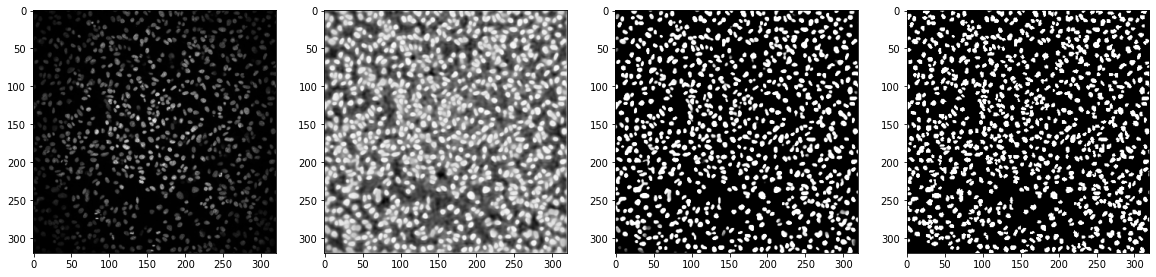

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 4, 1)
plt.imshow(image.cpu()[0][0], cmap='gray')
plt.subplot(1, 4, 2)
plt.imshow(y_pred.cpu().detach().numpy()[0][0], cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(torch.sigmoid(y_pred).cpu().detach().numpy()[0][0], cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(y_val[i], cmap='gray')
print(f'dice = {dice}, jaccard = {jaccard}')